In [ ]:
# import packages
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
 
from torch.utils.data import DataLoader
import torchvision.utils as vutils

from PIL import Image
from PIL import ImageFilter

In [ ]:
# constants
# Root directory for dataset
dataroot = "/content/drive/My Drive/Pytorch Summer Hackathon/Face Data by Race/White"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Number of epochs
epochs = 50

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent space (encoded vector size)
nz = 100

# Learning rate for optimizers
lr = 1e-3

In [ ]:
class Sharpen(object):
    """Sharpen the image in a sample."""

    def __call__(self, sample):
        # Apply sharp filter
        sharpened1 = sample.filter(ImageFilter.SHARPEN);
        sharpened2 = sharpened1.filter(ImageFilter.SHARPEN);

        return sample

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
transformer = transforms.Compose([
                               Sharpen(),
                               transforms.Resize(image_size),  transforms.RandomHorizontalFlip(),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
trainset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transformer)

# Create the dataloader
trainloader = DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

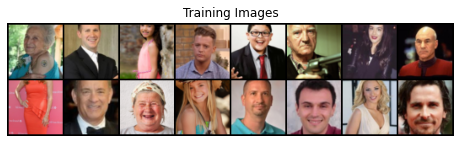

In [ ]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
 
net = Autoencoder().to(device)
print(net)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
decayRate = 0.9
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [ ]:
from tqdm.notebook import tqdm
train_loss = []
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for data in tqdm(trainloader):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    lr_scheduler.step()
    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, epochs, loss))



Epoch 1 of 50, Train Loss: 0.024



Epoch 2 of 50, Train Loss: 0.022



Epoch 3 of 50, Train Loss: 0.021


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 4 of 50, Train Loss: 0.020


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 5 of 50, Train Loss: 0.019


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 6 of 50, Train Loss: 0.018


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 7 of 50, Train Loss: 0.017


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 8 of 50, Train Loss: 0.017


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 9 of 50, Train Loss: 0.016


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 10 of 50, Train Loss: 0.016


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f3f201742b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel


Epoch 11 of 50, Train Loss: 0.015



Epoch 12 of 50, Train Loss: 0.015



Epoch 13 of 50, Train Loss: 0.015



Epoch 14 of 50, Train Loss: 0.015



Epoch 15 of 50, Train Loss: 0.014



Epoch 16 of 50, Train Loss: 0.014



Epoch 17 of 50, Train Loss: 0.014



Epoch 18 of 50, Train Loss: 0.014



Epoch 19 of 50, Train Loss: 0.014



Epoch 20 of 50, Train Loss: 0.014



Epoch 21 of 50, Train Loss: 0.013



Epoch 22 of 50, Train Loss: 0.013



Epoch 23 of 50, Train Loss: 0.013



Epoch 24 of 50, Train Loss: 0.013



Epoch 25 of 50, Train Loss: 0.013



Epoch 26 of 50, Train Loss: 0.013



Epoch 27 of 50, Train Loss: 0.013



Epoch 28 of 50, Train Loss: 0.013



Epoch 29 of 50, Train Loss: 0.013



Epoch 30 of 50, Train Loss: 0.013



Epoch 31 of 50, Train Loss: 0.013



Epoch 32 of 50, Train Loss: 0.013



Epoch 33 of 50, Train Loss: 0.013



Epoch 34 of 50, Train Loss: 0.013



Epoch 35 of 50, Train Loss: 0.013



Epoch 36 of 50, Train Loss: 0.012



Epoch 37 of 50, Train Loss: 0.012



Epoch 38 of 50, Train Loss: 0.012



Epoch 39 of 50, Train Loss: 0.012



Epoch 40 of 50, Train Loss: 0.012



Epoch 41 of 50, Train Loss: 0.012



Epoch 42 of 50, Train Loss: 0.012



Epoch 43 of 50, Train Loss: 0.012



Epoch 44 of 50, Train Loss: 0.012



Epoch 45 of 50, Train Loss: 0.012



Epoch 46 of 50, Train Loss: 0.012



Epoch 47 of 50, Train Loss: 0.012



Epoch 48 of 50, Train Loss: 0.012



Epoch 49 of 50, Train Loss: 0.012



Epoch 50 of 50, Train Loss: 0.012



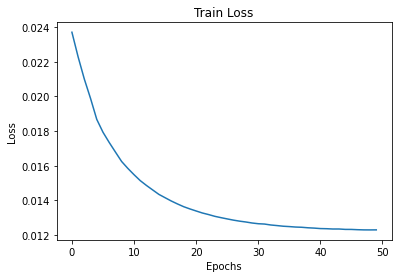

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('AA_AE_loss.png')

In [ ]:
torch.save(net, "/content/drive/My Drive/Pytorch Summer Hackathon/WhiteFaceAEModel-DConv.pth")

In [ ]:
torch.save(net.state_dict(), "/content/drive/My Drive/Pytorch Summer Hackathon/WhiteFaceAEModel-DConv.pt")

In [ ]:
testset = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/Pytorch Summer Hackathon/Face Data by Race/White",
                           transform=transformer)

# Create the dataloader
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


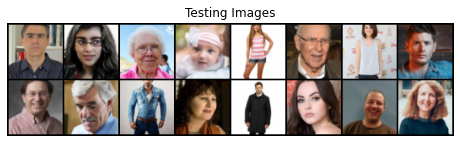

In [ ]:
# Plot some testing images
real_batch = next(iter(testloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

New Visualizations

In [ ]:
from IPython.display import Image
from IPython.core.display import Image, display
from random import randint
from torchvision.utils import save_image

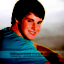

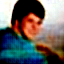

In [ ]:
org = trainset[randint(1, 1000)][0].unsqueeze(0)
new = net(org.to(device))
save_image(org.data.cpu(), 'sample_image.png')
save_image(new.data.cpu(), 'sample_image2.png')
display(Image('sample_image.png', width=300, unconfined=True))
display(Image('sample_image2.png', width=300, unconfined=True))